In [1]:
import cv2
import numpy as np
import onnxruntime as ort

In [17]:
ONNX_MODEL = "../models/weapons/best.onnx"
INPUT_IMAGE = "assets/test.jpg"
OUTPUT_IMAGE = "output.jpg"
CONFIDENCE_THRESHOLD = 0.4
IOU_THRESHOLD = 0.45
IMG_SIZE = 640

class_names = ['Gun', 'Explosive', 'Grenade', 'Knife']

In [12]:
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(ONNX_MODEL, providers=providers)

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [13]:
def preprocess(img):
    """Preprocess image for YOLO"""
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_normalized = img_rgb.astype(np.float32) / 255.0
    img_transposed = img_normalized.transpose(2, 0, 1)
    img_batch = np.expand_dims(img_transposed, axis=0)
    return img_batch

def xywh2xyxy(x):
    """Convert [x_center, y_center, w, h] to [x1, y1, x2, y2]"""
    y = np.copy(x)
    y[0] = x[0] - x[2] / 2  # x1
    y[1] = x[1] - x[3] / 2  # y1
    y[2] = x[0] + x[2] / 2  # x2
    y[3] = x[1] + x[3] / 2  # y2
    return y

def nms(boxes, scores, iou_threshold):
    """Non-maximum suppression"""
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]
    
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        
        iou = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(iou <= iou_threshold)[0]
        order = order[inds + 1]
    
    return keep

def postprocess(output, original_shape):
    """Postprocess YOLO output"""
    # Output shape: (1, 8, 8400)
    # Transpose to (8400, 8)
    predictions = output[0].transpose()  # Now (8400, 8)
    
    # Split into boxes and scores
    boxes = predictions[:, :4]  # (8400, 4) - x, y, w, h
    scores = predictions[:, 4:]  # (8400, 4) - class scores
    
    # Get class with highest score for each detection
    class_ids = np.argmax(scores, axis=1)
    confidences = np.max(scores, axis=1)
    
    # Filter by confidence threshold
    mask = confidences > CONFIDENCE_THRESHOLD
    boxes = boxes[mask]
    confidences = confidences[mask]
    class_ids = class_ids[mask]
    
    print(f"Detections after confidence filter: {len(boxes)}")
    
    if len(boxes) == 0:
        return []
    
    # Convert boxes from xywh to xyxy
    boxes_xyxy = np.array([xywh2xyxy(box) for box in boxes])
    
    # Scale boxes to original image size
    scale_x = original_shape[1] / IMG_SIZE
    scale_y = original_shape[0] / IMG_SIZE
    boxes_xyxy[:, [0, 2]] *= scale_x
    boxes_xyxy[:, [1, 3]] *= scale_y
    
    # Apply NMS
    indices = nms(boxes_xyxy, confidences, IOU_THRESHOLD)
    
    print(f"Detections after NMS: {len(indices)}")
    
    # Prepare final detections
    detections = []
    for i in indices:
        detections.append({
            'box': boxes_xyxy[i],
            'confidence': confidences[i],
            'class_id': class_ids[i],
            'class_name': class_names[class_ids[i]] if class_ids[i] < len(class_names) else f'class_{class_ids[i]}'
        })
    
    return detections

def draw_detections(img, detections):
    """Draw bounding boxes on image"""
    for det in detections:
        box = det['box'].astype(int)
        conf = det['confidence']
        class_name = det['class_name']
        
        # Draw box
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        
        # Draw label
        label = f"{class_name} {conf:.2f}"
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(img, (box[0], box[1] - 20), (box[0] + w, box[1]), (0, 255, 0), -1)
        cv2.putText(img, label, (box[0], box[1] - 5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
    
    return img

Detections after confidence filter: 10
Detections after NMS: 1
Found 1 detections
  1. Gun: 0.652


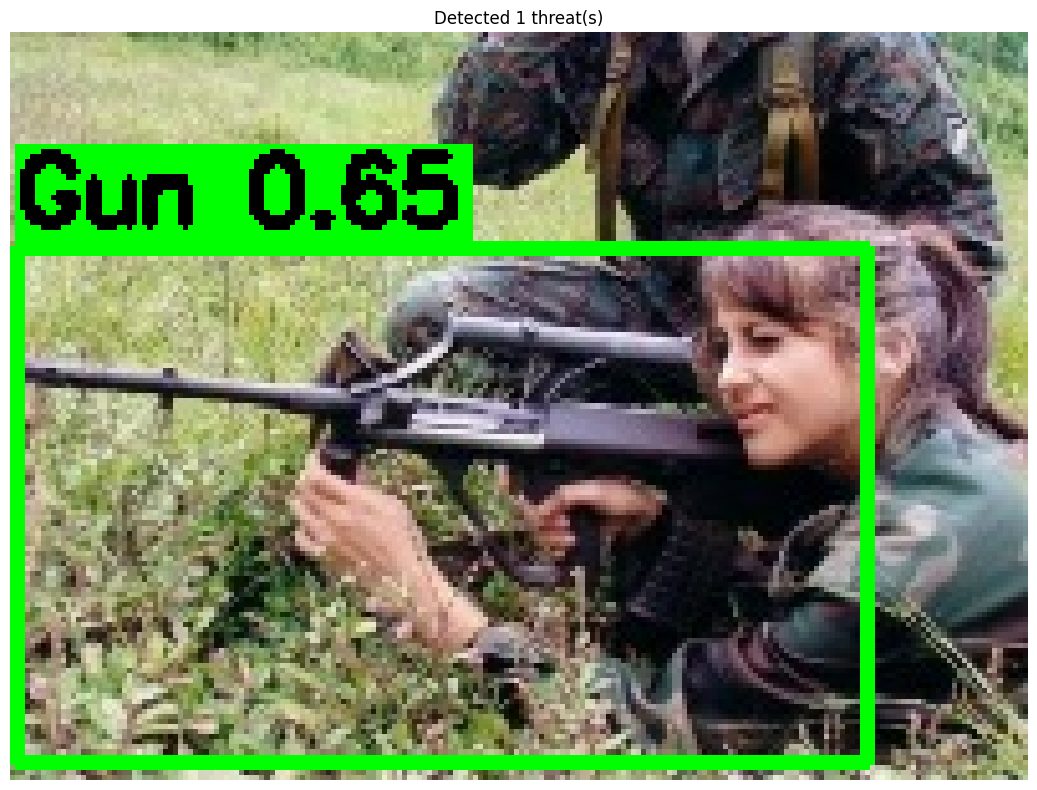


Saved to: output.jpg


In [19]:
import matplotlib.pyplot as plt

img = cv2.imread(INPUT_IMAGE)
original_shape = img.shape[:2]

# Preprocess and run inference
img_input = preprocess(img)
outputs = session.run([output_name], {input_name: img_input})

# Postprocess
detections = postprocess(outputs[0], original_shape)

print(f"Found {len(detections)} detections")
for i, det in enumerate(detections):
    print(f"  {i+1}. {det['class_name']}: {det['confidence']:.3f}")

# Draw and display
if len(detections) > 0:
    img_annotated = draw_detections(img.copy(), detections)
    
    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img_annotated, cv2.COLOR_BGR2RGB)
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Detected {len(detections)} threat(s)")
    plt.tight_layout()
    plt.show()
    
    # Also save
    cv2.imwrite(OUTPUT_IMAGE, img_annotated)
    print(f"\nSaved to: {OUTPUT_IMAGE}")
else:
    print("No detections found!")